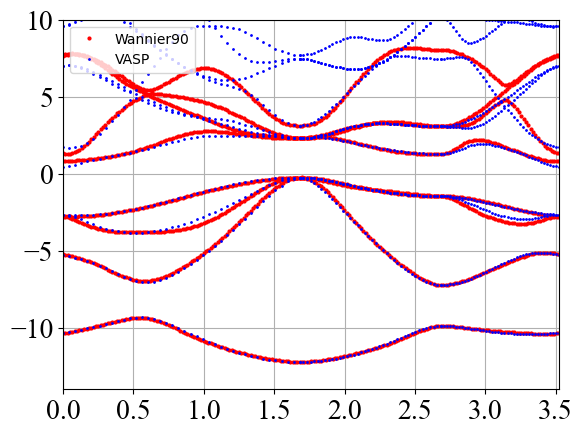

In [16]:

# 通过读取Wannier90给出的能带数据wannier90_band.dat，与VASP结合vaspkit得到的数据BAND.dat
# 来绘制 wannier插值后的能带与VASP计算的能带之间的差距
#-----------------------------------------------------------------
from cProfile import label
import os
import numpy as np
import matplotlib.pyplot as plt
#-----------------------------------------------------------------
def dataread():
    da1 = "wannier90_band.dat"
    x0 = []
    y0 = []
    with open(da1) as file:
            fermi =  5.759501
            da = file.readlines()
            for f1 in da:
               
                temp = f1.strip().split()
                
                # 移除字符串头尾指定的字符（默认为空格）,并以空格将这些字符串分开
                if len(temp) != 0:
                    x0.append(float(temp[0]))
                    y0.append(float(temp[1])-fermi)#wannier90输出没有减去fermi因此在此处减去
    plt.scatter(x0,y0,s = 1, color = 'red', alpha = 0.7,marker = '.')
    plt.plot(x0,y0,'ro',markersize = 2,label="Wannier90")

    da2 = "BAND.dat"
    #需要手动删除开头的几行带有#号的
    x1 = []
    y1 = []
    with open(da2) as file:
            da = file.readlines()
            for f1 in da:
                temp = f1.strip().split()  # 移除字符串头尾指定的字符（默认为空格）,并以空格将这些字符串分开
                if len(temp) == 2:
                    x1.append(float(temp[0]))
                    y1.append(float(temp[1]))
    #plt.scatter(x1,y1 ,s = 1, color = 'blue', alpha = 0.7, marker = '.')
    plt.plot(x1,y1,'bo',markersize = 1,label = "VASP")
    plt.yticks(fontproperties='Times New Roman', size = 20)
    plt.xticks(fontproperties='Times New Roman', size = 20)
    plt.xlim(np.min(x0),np.max(x0))
    plt.legend(loc = 2,ncol = 1)
    plt.grid(True)
    plt.ylim(-14,10)#需要手动调整能量范围
    picname = "band-compare.png"
    plt.savefig(picname, dpi = 600, bbox_inches = 'tight')
#--------------------------------------------------------------
def main():
    os.chdir(os.getcwd())# 确定用户执行路径
    dataread()
#----------------------------------------------------------------
if __name__=='__main__':
    main()

正在构建矩阵
--------------------------------------------
正在求解矩阵


C:\anaconda\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\anaconda\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


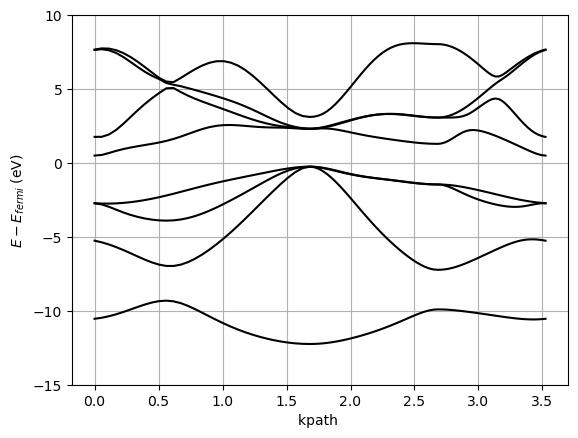

处理完成


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
 
start_time = time.process_time()
#读取hr当中的信息
with open("wannier90_hr.dat", "r") as f:
    lines = f.readlines()
    f.close()
#需要根据具体能带数进行调整,从数据第二行当中读取所需的能带属
num_wan = int(lines[1].strip())
#读取第三行当中的权重个数
Nrpts = int(lines[2].strip())
# 初始化一个列表来存储数据
data = []

# 从第四行开始读取数据并提取所有组元，直到data中的数据个数等于Nrpts
for line in lines[3:]:
    if len(data) >= Nrpts:
        break
    # 将当前行的数据组元分割开来，并加入data中
    elements = line.strip().split()
    data.extend(elements)
# 将 data 转换为浮点数列表
data = [float(x) for x in data]
#晶格常数
a = 5.43
#基矢需要根据poscar当中的数据修改
basis_vector = np.array([[0.5, 0.5, 0],[0, 0.5, 0.5],[0.5, 0, 0.5]])*a
#确定k点的精度
k_mesh = 30
#fermi能的数值
E_fermi = 5.76
#k点的路径
K_point_path = [[-1/3, 2/3, 0], [0.00000,0.00000,0.00000], [0.0,0.50000,0.00000], [-1/3,2/3,0.00000]]



Symmetry_point_label1 = "K"
Symmetry_point_label2 = "G"
Symmetry_point_label3 = "M"
Symmetry_point_label4 = "K"
 
#确定能量的上下限
lower_bound = -15
upper_bound = 10

#计算倒格矢根据公式计算
V = np.dot(basis_vector[0], np.cross(basis_vector[1], basis_vector[2]))
rec = [np.cross(basis_vector[1], basis_vector[2]) * 2 * np.pi / V,
       np.cross(basis_vector[2], basis_vector[0]) * 2 * np.pi / V,
       np.cross(basis_vector[0], basis_vector[1]) * 2 * np.pi / V]
 
#将k点转化为倒空间格点
for i in range(len(K_point_path)):
    K_point_path[i] = K_point_path[i][0] * rec[0] + K_point_path[i][1] * rec[1] + K_point_path[i][2] * rec[2]

#定义k点路径
def k_path():
    k_point = []
    for i in range(len(K_point_path) - 1):
        interval = np.array(K_point_path[i + 1]) - np.array(K_point_path[i])
        interval = interval / k_mesh
        for j in range(k_mesh + 1):
            k_point.append(np.array(K_point_path[i]) + j * interval)
    return k_point
 
#定义波函数，R是提取数据中的位移矢量exp（i*（k*R））
def phase(R1, R2, R3, k1, k2, k3):
    R1_vector = R1 * np.array(basis_vector[0])
    R2_vector = R2 * np.array(basis_vector[1])
    R3_vector = R3 * np.array(basis_vector[2])
    R_vec = R1_vector + R2_vector + R3_vector
    inner_product = np.dot(R_vec, [k1, k2, k3])
    return np.exp(1j * inner_product)
 
# 从数据中提取矩阵元和位移矢量
def matrix_element():
    factor = []
    R = []
#初始化矩阵元与位移矢量的结构
    for i in range(num_wan):
        factor.append([])
        R.append([])
        for j in range(num_wan):
            factor[-1].append([])
            R[-1].append([])

    for line in lines:
        if len(line.split()) == 7:  # 确保提取的是含有信息的数据
            real_part = round(float(line.split()[5]), 3)#保留3位小数
            imag_part = round(float(line.split()[6]), 3)
            factor[int(line.split()[3]) - 1][int(line.split()[4]) - 1].append(
                real_part + 1j * imag_part)  # 提取信息当中的实部和虚部
            R[int(line.split()[3]) - 1][int(line.split()[4]) - 1].append(
                [float(line.split()[0]), float(line.split()[1]), float(line.split()[2])])  # 提取信息当中的位移矢量
    return factor, R


# 计算 factor 的实部和虚部分别除以 data 对应值的函数
def divide_factor_by_data(data, factor):
    normalized_factor = []
    data_index = 0

    for i in range(len(factor)):
        row = []
        for j in range(len(factor[i])):
            col = []
            for k in range(len(factor[i][j])):
                if data_index < len(data):
                    # 获取 factor 数组中的当前复数
                    factor_vector = factor[i][j][k]
                    
                    # 获取 data 中的当前值
                    data_value = data[data_index]
                    
                    # 避免除以零
                    if data_value != 0:
                        # 分别计算 factor 矢量的实部和虚部与 data 的比值
                        real_part = factor_vector.real / data_value
                        imag_part = factor_vector.imag / data_value
                        divided_vector = real_part + 1j * imag_part
                    else:
                        divided_vector = factor_vector
                        
                    col.append(divided_vector)
                    # 循环 data_index 以便重新对应
                    data_index = (data_index + 1) % len(data)
            row.append(col)
        normalized_factor.append(row)

    return normalized_factor



def matrix_construct(factor_normalized, R, k1, k2, k3):
    H = np.zeros((num_wan, num_wan),dtype='complex')#根据能带条数定义矩阵（X*X）
    #构建矩阵
    for i in range(num_wan):
        for j in range(num_wan):
            for k in range(len(R[i][j])):#可以调节所需的近邻
                H[i][j] += factor_normalized[i][j][k] * phase(R[i][j][k][0], R[i][j][k][1], R[i][j][k][2], k1, k2, k3)
    return H
 
 
# 运行能带结构计算
def run():
    solution = [[] for _ in range(num_wan)]

    k_line = k_path()
    print('正在构建矩阵')
    factor, R = matrix_element()
    # 计算处理后的 R
    #print(factor[5][0])
    factor_normalized = divide_factor_by_data(data, factor)
    #print(factor_normalized[5][0])
    print('--------------------------------------------')
    print('正在求解矩阵')
    for l, k in enumerate(k_line):
        H = matrix_construct(factor_normalized, R, k[0], k[1], k[2])
        eig = np.linalg.eigvals(H)
        eig = np.sort(eig)
        for i in range(len(eig)):
            solution[i].append(eig[i] - E_fermi)
    
    return solution, k_line

# 计算绘图的k点距离
def k_point_distances(k_points):
    distances = [0]
    for i in range(1, len(k_points)):
        dk = np.linalg.norm(k_points[i] - k_points[i - 1])
        distances.append(distances[-1] + dk)
    return distances
#将每个k点之间的距离求出作为x轴坐标
solution, k_line = run()
k_distances = k_point_distances(k_line)

ax = plt.axes()
for band in solution:
    ax.plot(k_distances, band, color='black')

plt.ylim(lower_bound, upper_bound)
plt.grid(True)
plt.ylabel(r"$E - E_{fermi}$"' (eV)')
plt.xlabel("kpath ")
plt.show()

end_time = time.process_time()

print("处理完成")
# print('CPU执行时间（分钟）=', (end_time - start_time) / 60)
